In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
bool_cmap = colors.ListedColormap([(1, 1, 1, 0), 'black'])
from fastadjust.io import h5read
from flyion import initialize, fly
from flyion.trajectory import final_position, trajectory

In [2]:
# constants
from scipy.constants import centi, milli, e, m_e, m_u
mass_NO = 30.0061 * m_u
mass_O = 15.9994 * m_u
mass_N = 14.0067 * m_u
dt = 2e-9

## Fast Adjust Potential Arrays

In [3]:
# SIMION array
fil = os.path.join(r"./", "mcp.h5")
fa = h5read(fil)
# move xy origin to center of the grid
fa.x0 = - (fa.nx - 1) * fa.dx / 2 
fa.y0 = - (fa.ny - 1) * fa.dy / 2 - 0.01275
fa.z0 = -0.025

## Single ion trajectory

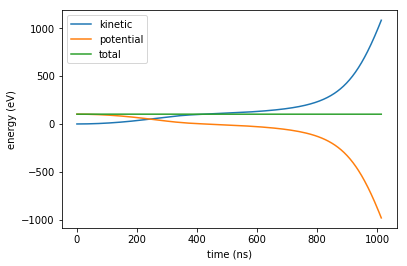

In [4]:
voltages = np.array([0, -1000, +200], dtype='float64')
tr = trajectory(fa,
                lambda t: voltages,
                t0=0.0,
                x0=[0.0, 0.0, 0.0],
                v0=[0.0, 0.0, 0.0],
                charge=e,
                mass=mass_NO,
                dt=dt)

# plot
fig, ax = plt.subplots()

ax.plot(1e9 * tr.index, tr.KE / e, label="kinetic")
ax.plot(1e9 * tr.index, tr.PE / e, label="potential")
ax.plot(1e9 * tr.index, (tr.PE + tr.KE) / e, label="total")

# format
ax.legend()
ax.set_ylabel("energy (eV)")
ax.set_xlabel("time (ns)")

# output
plt.show()

## Monte Carlo
### static voltages

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


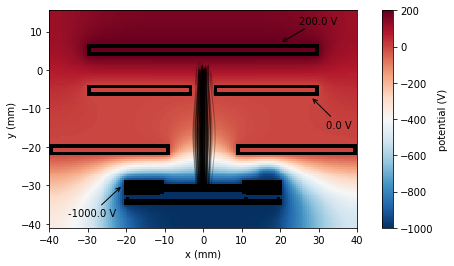

In [5]:
el = fa.electrode
phi = fa.potential(voltages)

# potential
zg = 50
fig, ax = plt.subplots(figsize=(9, 4))
c0 = ax.imshow(phi[:, :, zg].T, origin='lower', extent=fa.extent[:4] / milli, cmap='RdBu_r')
cbar = fig.colorbar(c0, label='potential (V)')
c0 = ax.imshow(el[:, :, zg].T, origin='lower', extent=fa.extent[:4] / milli, cmap=bool_cmap, vmin=0, vmax=1)

# ions
initial = initialize(100, sigma_x=1e-3)
df = fly(fa, lambda t: voltages, initial, e, mass_NO, dt=dt, mode="full")
for i in np.unique(df.index.get_level_values(0)):
    tr = df.loc[i]
    ax.plot(tr.x*1e3, tr.y*1e3, c='k', lw=1, alpha=0.3)

# annotate
ax.annotate(f"{voltages[0]} V", xy=(28, -7),
            arrowprops=dict(arrowstyle='->'), xytext=(32, -15))
ax.annotate(f"{voltages[1]} V", xy=(-21, -30),
            arrowprops=dict(arrowstyle='->'), xytext=(-35, -38))
ax.annotate(f"{voltages[2]} V", xy=(20, 7),
            arrowprops=dict(arrowstyle='->'), xytext=(25, 12))
    
# format
ax.set_aspect('equal')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

# output
out_fil = "ions.png"
plt.savefig(out_fil, bbox_inches="tight", dpi=200)
plt.show()

In [6]:
# simulate tof
initial = initialize(1000, sigma_x=1e-3)
mass_values = [mass_NO, mass_O, mass_N]
labels = ["NO$^+$", "O$^+$", "N$^+$"]
ion_flight = dict()
for mass, lbl in zip(mass_values, labels):
    ion_flight[lbl] = fly(fa, lambda t: voltages, initial, e, mass, dt=dt, mode="final")

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:52<00:00,  9.09it/s]


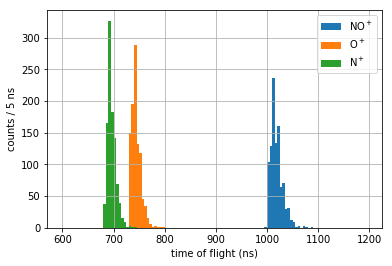

In [7]:
# plot
fig, ax = plt.subplots()

bins = np.arange(600, 1200, 5)
for lbl, ff  in ion_flight.items():
    (ff[ff.time > 500e-9].time * 1e9).hist(ax=ax, bins=bins, label=lbl)

# format
ax.legend()
ax.set_xlabel('time of flight (ns)')
ax.set_ylabel('counts / 5 ns')

# output
plt.show()